# Table of contents
1. [Fine tune tuberculosis detector on data without augmentation](#no_augmentation)
    1. [Train classifier with different parameters' values](#try_hyperparams_no_augmentation)
    2. [Select best hyperparameters' values based on validation accuracy](#select_hyperparams_no_augmentation)
    3. [Get test accuracy of the best model](#test_accuracy_no_augmentation)
2. [Train tuberculosis detector on data with basic augmentation](#no_augmentation)
3. [Train tuberculosis detector on data with augmented with GAN](#no_augmentation)


# Train tuberculosis detector on data augmented with CycleGAN4<a name='no_augmentation'></a>

In [1]:
%matplotlib inline
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, BatchNormalization, GlobalAveragePooling2D, Dropout, Dense, LeakyReLU
from tensorflow.keras import Model
from itertools import product
from math import ceil

In [2]:
# Normalize [-1, 1] input images
def normalize(img):
    img = img / 127.5 - 1
    return img


def denormalize(img):
    img = (img+1)*127.5
    return img.astype(np.uint8)

In [3]:
trainDir = '../xrays_cyclegan4/train'
validDir = '../xrays_256/validate'

IMG_SIZE = 128
BATCH_SIZE = 16
image_generator = ImageDataGenerator(preprocessing_function=normalize)

flow_args = {
    'target_size': (IMG_SIZE, IMG_SIZE),
    'color_mode': 'rgb',
    'batch_size': BATCH_SIZE,
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': 1
}

train_generator = image_generator.flow_from_directory(
    directory=trainDir,
    **flow_args
)

validation_generator = image_generator.flow_from_directory(
    directory=validDir,
    **flow_args
)

Found 1002 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


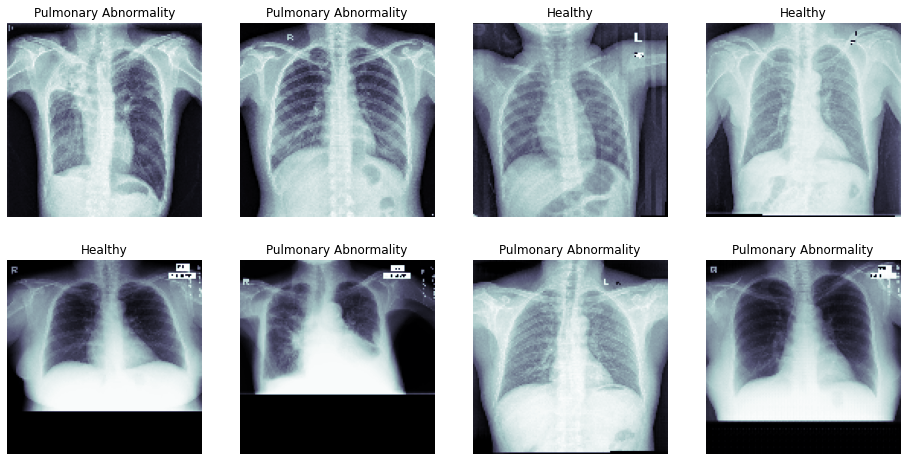

In [4]:
import matplotlib.pyplot as plt

label_to_name = (
    'Healthy',
    'Pulmonary Abnormality'
)

images, labels = next(train_generator)
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i, l, a in zip(images, labels, ax.flatten()):
    a.imshow(denormalize(i[:, :, 0]), cmap='bone')
    a.set_title(label_to_name[np.argmax(l)])
    a.axis('off')

Model is based on https://github.com/zeeshannisar/Transfer-Learning-and-Fine-Tuning-with-Pre-Trained-Networks/blob/master/Transfer%20Learning%20with%20VGG16/Fine%20tuning%20with%20Pretrained%20VGG16%20for%20Tuberculosis%20Classification.ipynb

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

CLASS_COUNT = 2 # normal and abnormal

In [6]:
def get_model(optimizer, learning_rate, dropout_rate, units):
    img_shape = (IMG_SIZE, IMG_SIZE, 3)
    vgg16_model = VGG16(input_shape=img_shape,
                        include_top=False, weights='imagenet')
    vgg16_model.trainable = False

    inputs = Input(img_shape)
    outputs = vgg16_model(inputs)
    outputs = BatchNormalization(name='BatchNormalization')(outputs)
    outputs = GlobalAveragePooling2D()(outputs)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = Dense(units)(outputs)
    outputs = LeakyReLU(alpha=0.1)(outputs)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = Dense(CLASS_COUNT, activation='sigmoid')(outputs)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives()
        ]
    )

    model.summary()
    return model

In [7]:
TRAIN_COUNT = train_generator.samples
VALIDATION_COUNT = validation_generator.samples
TUNE_EPOCHS = 100

In [8]:
HYPERPARAMETERS = {
    'optimizer': [tf.keras.optimizers.Adam],
    'learning_rate': [1e-4, 2e-4, 3e-4],
    'dropout_rate': [i/10 for i in range(3, 6)],
    'units': [256]
}

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def get_callbacks(idx):
    checkpoint_callback = ModelCheckpoint(
        f'checkpoint/{idx}/100',
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True
    )
    stop_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=15)
    board_callback = TensorBoard(log_dir=f'logs/cyclegan4')
    
    return checkpoint_callback, stop_callback, board_callback

In [10]:
trainDir = '../xrays_cyclegan4/train'
validDir = '../xrays_256/validate'

IMG_SIZE = 128
BATCH_SIZE = 16
image_generator = ImageDataGenerator(preprocessing_function=normalize)

flow_args = {
    'target_size': (IMG_SIZE, IMG_SIZE),
    'color_mode': 'rgb',
    'batch_size': BATCH_SIZE,
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': 1
}

train_generator = image_generator.flow_from_directory(
    directory=trainDir,
    **flow_args
)

validation_generator = image_generator.flow_from_directory(
    directory=validDir,
    **flow_args
)

Found 1002 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def get_callbacks(idx):
    checkpoint_callback = ModelCheckpoint(
        f'checkpoint/cyclegan4',
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True
    )
    board_callback = TensorBoard(log_dir=f'logs/cyclegan4')
    
    return checkpoint_callback, board_callback

In [12]:
TRAIN_COUNT = train_generator.samples

In [13]:
model = tf.keras.models.load_model('checkpoint/cyclegan4')

In [22]:
model = get_model(tf.keras.optimizers.Adam, 3e-4, 0.3, 256)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
BatchNormalization (BatchNor (None, 4, 4, 512)         2048      
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0     

In [14]:
model.fit(
    train_generator,
    steps_per_epoch=ceil(TRAIN_COUNT/BATCH_SIZE),
    validation_data=validation_generator,
    validation_steps=ceil(VALIDATION_COUNT/BATCH_SIZE),
    epochs=TUNE_EPOCHS,
    callbacks=get_callbacks(i),
    initial_epoch=70
)

Epoch 71/100
63/63 [==============================] - 12s 137ms/step - loss: 0.6599 - accuracy: 0.6327 - false_positives: 371.0000 - false_negatives: 390.0000 - val_loss: 0.6049 - val_accuracy: 0.8354 - val_false_positives: 16.0000 - val_false_negatives: 13.0000

Epoch 00071: val_accuracy improved from -inf to 0.83544, saving model to checkpoint/cyclegan4
INFO:tensorflow:Assets written to: checkpoint/cyclegan4/assets
Epoch 72/100
63/63 [==============================] - 4s 58ms/step - loss: 0.6574 - accuracy: 0.6038 - false_positives: 409.0000 - false_negatives: 407.0000 - val_loss: 0.6067 - val_accuracy: 0.7848 - val_false_positives: 15.0000 - val_false_negatives: 20.0000

Epoch 00072: val_accuracy did not improve from 0.83544
Epoch 73/100
63/63 [==============================] - 4s 58ms/step - loss: 0.6369 - accuracy: 0.6427 - false_positives: 365.0000 - false_negatives: 370.0000 - val_loss: 0.5560 - val_accuracy: 0.8608 - val_false_positives: 10.0000 - val_false_negatives: 13.0000



63/63 [==============================] - 4s 58ms/step - loss: 0.5505 - accuracy: 0.7046 - false_positives: 296.0000 - false_negatives: 300.0000 - val_loss: 0.5655 - val_accuracy: 0.7089 - val_false_positives: 23.0000 - val_false_negatives: 22.0000

Epoch 00096: val_accuracy did not improve from 0.86076
Epoch 97/100
63/63 [==============================] - 4s 58ms/step - loss: 0.5639 - accuracy: 0.6956 - false_positives: 311.0000 - false_negatives: 312.0000 - val_loss: 0.5685 - val_accuracy: 0.7215 - val_false_positives: 23.0000 - val_false_negatives: 22.0000

Epoch 00097: val_accuracy did not improve from 0.86076
Epoch 98/100
63/63 [==============================] - 4s 58ms/step - loss: 0.5668 - accuracy: 0.6976 - false_positives: 298.0000 - false_negatives: 314.0000 - val_loss: 0.5248 - val_accuracy: 0.7468 - val_false_positives: 22.0000 - val_false_negatives: 19.0000

Epoch 00098: val_accuracy did not improve from 0.86076
Epoch 99/100
63/63 [==============================] - 4s 58ms/

In [15]:
%load_ext tensorboard
%tensorboard --logdir logs/cyclegan4

## Test model augmented with FastGAN

In [16]:
test_dir = '../xrays_256/test'

In [17]:
test_generator = image_generator.flow_from_directory(
    directory=test_dir,
    **flow_args
)

Found 79 images belonging to 2 classes.


In [18]:
TEST_COUNT = test_generator.samples

In [21]:
print('Evaluate model with best hyperparameters on test data:')
for hp, v in zip((k for k in HYPERPARAMETERS), (tf.keras.optimizers.Adam, 3e-4, 0.3, 256)):
    print(f'{hp}: {v}')

model = tf.keras.models.load_model(f'checkpoint/cyclegan4')
metrics = model.evaluate(
    test_generator,
    steps=ceil(TEST_COUNT/BATCH_SIZE),
    return_dict=True
)
accuracy = metrics['accuracy']
false_positives = metrics[f'false_positives']
false_negatives = metrics[f'false_negatives']

print(f'Accuracy on test data: {accuracy:.2f}')
print(f'False positives: {false_positives:.2f}')
print(f'False negatives: {false_negatives:.2f}')

Evaluate model with best hyperparameters on test data:
optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
learning_rate: 0.0003
dropout_rate: 0.3
units: 256
5/5 [==============================] - 1s 57ms/step - loss: 0.6274 - accuracy: 0.6962 - false_positives: 28.0000 - false_negatives: 23.0000
Accuracy on test data: 0.70
False positives: 28.00
False negatives: 23.00
